In [1]:
import pickle
import pumpp
import numpy as np
import librosa
import os
from glob import glob

import tensorflow as tf
import keras as K
import pescador
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit

Using TensorFlow backend.


In [2]:
SEED = 20170401

In [3]:
DATA_DIR = '/home/bmcfee/working/chords/pump'

In [4]:
# Reload the pump
with open('/home/bmcfee/working/chords/pump.pkl', 'rb') as fd:
    pump = pickle.load(fd)

In [5]:
# Calculate the number of frames

MAX_SAMPLES = 128

duration = 8.0

pump['cqt'].sr

n_frames = librosa.time_to_frames(duration,
                                  sr=pump['cqt'].sr,
                                  hop_length=pump['cqt'].hop_length)[0]

sampler = pump.sampler(MAX_SAMPLES, n_frames, random_state=SEED)

In [6]:
n_frames

86

In [7]:
def data_sampler(fname, sampler):

    data = np.load(fname)
    d2 = dict(data)
    data.close()
    data = d2
    
    yield from sampler(data)

In [8]:
def data_generator(tracks, sampler, k, batch_size=16, augmentation=False, **kwargs):
    
    seeds = []
    for track in tracks:
        
        fname = os.path.join(DATA_DIR, os.path.extsep.join([track, 'npz']))
        seeds.append(pescador.Streamer(data_sampler, fname, sampler))
        
        if augmentation:
            for fname in sorted(glob(os.path.join(DATA_DIR, '{}.*.npz'.format(track)))):
                seeds.append(pescador.Streamer(data_sampler, fname, sampler))
        
    # Send it all to a mux
    mux = pescador.Mux(seeds, k, **kwargs)
    
    if batch_size == 1:
        return mux
    else:
        return pescador.BufferedStreamer(mux, batch_size)

In [9]:
def wrap(gen):
    
    for batch in gen:
        yield [batch[0], batch[1]], list(batch[2:])

# Construct the model

In [10]:
pump.fields

{'chord_struct/bass': Tensor(shape=(None, 1), dtype=<class 'int'>),
 'chord_struct/pitch': Tensor(shape=(None, 12), dtype=<class 'bool'>),
 'chord_struct/root': Tensor(shape=(None, 1), dtype=<class 'int'>),
 'chord_tag/chord': Tensor(shape=(None, 1), dtype=<class 'int'>),
 'cqt/dphase': Tensor(shape=(None, 216, 1), dtype=<class 'numpy.float32'>),
 'cqt/mag': Tensor(shape=(None, 216, 1), dtype=<class 'numpy.float32'>)}

In [11]:
len(pump['chord_tag'].vocabulary())

170

In [12]:
pump['cqt'].layers()

{'cqt/dphase': <tf.Tensor 'cqt/dphase:0' shape=(?, ?, 216, 1) dtype=float32>,
 'cqt/mag': <tf.Tensor 'cqt/mag:0' shape=(?, ?, 216, 1) dtype=float32>}

In [13]:
LAYERS = pump['cqt'].layers()

x = LAYERS['cqt/mag']

b = K.layers.BatchNormalization()(x)

c0 = K.layers.Convolution2D(1, (5, 5), padding='same',
                            activation='relu',
                            data_format='channels_last')(b)

c1 = K.layers.Convolution2D(36, (1, int(c0.shape[2])), padding='valid', activation='relu',
                            data_format='channels_last')(c0)

r1 = K.layers.Lambda(lambda x: K.backend.squeeze(x, axis=2))(c1)

rs = K.layers.Bidirectional(K.layers.GRU(64, return_sequences=True))(r1)

p0 = K.layers.Dense(len(pump['chord_tag'].vocabulary()), activation='softmax',
                    bias_regularizer=K.regularizers.l2())

p1 = K.layers.TimeDistributed(p0)(rs)

model = K.models.Model(x, p1)

# Run a train-test split

In [ ]:
index = pd.read_json('/home/bmcfee/working/chords/artist_index.json', typ='series')

splitter_tt = GroupShuffleSplit(n_splits=1, random_state=SEED)
for train_, test in splitter_tt.split(index, groups=list(index)):
    idx_train_ = index.iloc[train_]
    idx_test = index.iloc[test]
    splitter_tv = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
    
    for train, val in splitter_tv.split(idx_train_, groups=list(idx_train_)):
        idx_train = idx_train_.iloc[train]
        idx_val = idx_train_.iloc[val]
    
        gen_train = data_generator(idx_train.index, sampler, 1024, augmentation=True, 
                                   lam=8, batch_size=32, revive=True, random_state=SEED)
        
        gen_val = data_generator(idx_val.index, sampler, len(idx_val),
                                 batch_size=32, revive=True, random_state=SEED)
        

        model.compile(K.optimizers.Adam(),
                      'sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'])

        model.fit_generator(gen_train.tuples('cqt/mag', 'chord_tag/chord'), 512, 100,
                            validation_data=gen_val.tuples('cqt/mag', 'chord_tag/chord'),
                            validation_steps=1024,
                            callbacks=[K.callbacks.ModelCheckpoint('/home/bmcfee/working/chords/model_simple_ckpt.pkl',
                                                                   save_best_only=True,
                                                                   verbose=1),
                                       K.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
                                       K.callbacks.EarlyStopping(patience=15, verbose=0)])

Epoch 1/100
512/512 [==============================] - 197s - loss: 2.3445 - sparse_categorical_accuracy: 0.4485 - val_loss: 1.8083 - val_sparse_categorical_accuracy: 0.5395
Epoch 2/100
512/512 [==============================] - 195s - loss: 1.4236 - sparse_categorical_accuracy: 0.6095 - val_loss: 1.5899 - val_sparse_categorical_accuracy: 0.5733
Epoch 5/100
512/512 [==============================] - 196s - loss: 1.3296 - sparse_categorical_accuracy: 0.6245 - val_loss: 1.5121 - val_sparse_categorical_accuracy: 0.5923
Epoch 9/100
512/512 [==============================] - 197s - loss: 1.2967 - sparse_categorical_accuracy: 0.6313 - val_loss: 1.5207 - val_sparse_categorical_accuracy: 0.5889
Epoch 11/100
512/512 [==============================] - 194s - loss: 1.3037 - sparse_categorical_accuracy: 0.6324 - val_loss: 1.5871 - val_sparse_categorical_accuracy: 0.5798
Epoch 12/100
512/512 [==============================] - 195s - loss: 1.3036 - sparse_categorical_accuracy: 0.6304 - val_loss: 1.6

In [30]:
model.load_weights('/home/bmcfee/working/chords/model_simple_ckpt.pkl')

# Diagnostics

In [31]:
import pandas as pd

In [32]:
import jams.display
import matplotlib.pyplot as plt
%matplotlib nbagg
import librosa.display

<IPython.core.display.Javascript object>


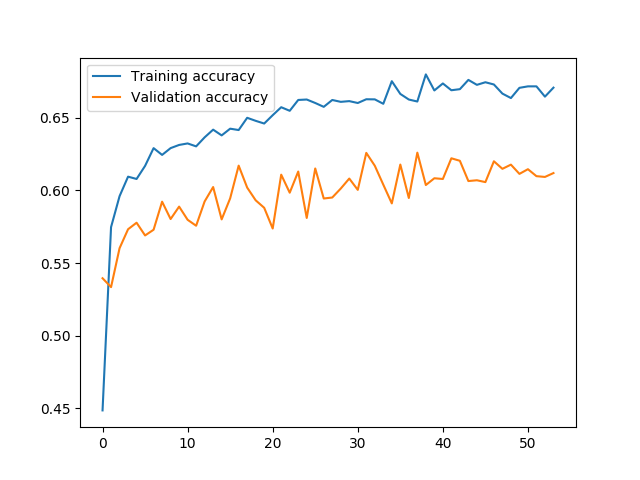

In [33]:
history = pd.DataFrame.from_dict(model.history.history)
plt.figure()

plt.plot(history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.legend(loc='best')

In [34]:
l1 = model.get_weights()[4]

<IPython.core.display.Javascript object>


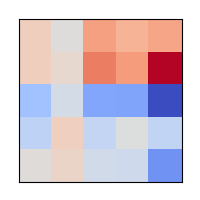

In [35]:
plt.figure(figsize=2 * np.asarray(l1.shape[2:]))

pi = 0
for f in range(l1.shape[3]):
    for c in range(l1.shape[2]):
        pi += 1
        plt.subplot(l1.shape[3], l1.shape[2], pi)
        librosa.display.specshow(l1[:, :, c, f].T)#, vmin=l1.min(), vmax=l1.max())
        
        
plt.tight_layout()

In [36]:
l2 = model.get_weights()[6].squeeze()
l2 = librosa.util.axis_sort(l2)

<IPython.core.display.Javascript object>


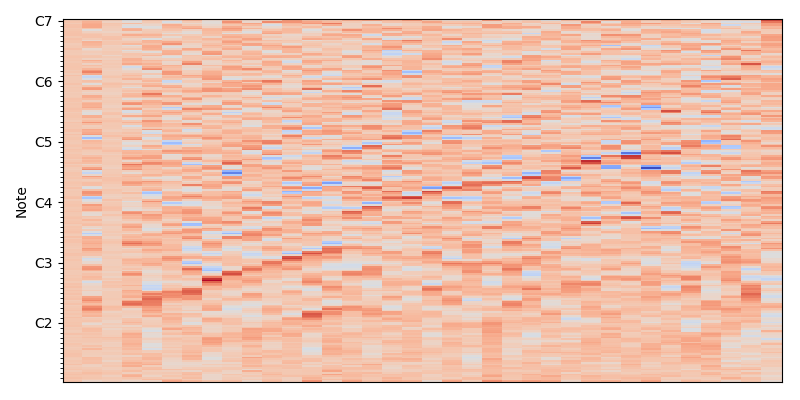

In [37]:
plt.figure(figsize=(8,4))
librosa.display.specshow(l2, y_axis='cqt_note', sr=pump.ops[0].sr, bins_per_octave=36)
plt.tight_layout()

---
# Validation viz

In [38]:
import pandas as pd
import jams

from tqdm import tqdm_notebook as tqdm

from IPython.display import Audio

import jams

import librosa

In [39]:
def score_model(pump, model, idx,
                features='/home/bmcfee/working/chords/pump',
                refs='/home/bmcfee/data/eric_chords/references_v2/'):
    
    results = {}
    for item in tqdm(idx.index):
        jam = jams.load('{}/{}.jams'.format(refs, item), validate=False)
        datum = np.load('{}/{}.npz'.format(features, item))['cqt/mag']
        
        ann = pump.ops[1].inverse(model.predict(datum)[0])
        results[item] = jams.eval.chord(jam.annotations['chord', 0], ann)
        
    return pd.DataFrame.from_dict(results, orient='index')

In [ ]:
df = score_model(pump, model, idx_test)

In [ ]:
dfr = df[['thirds', 'triads', 'tetrads', 'root', 'mirex', 'majmin', 'sevenths']]

In [40]:
dfr.describe()

,thirds,triads,tetrads,root,mirex,majmin,sevenths
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.769563,0.727529,0.590000,0.804221,0.794089,0.783547,0.646078
std,0.148312,0.187265,0.202314,0.120829,0.136100,0.154343,0.189277
min,0.049119,0.034102,0.026934,0.060540,0.049119,0.050010,0.026934
25%,0.680561,0.636185,0.463364,0.734355,0.735562,0.709487,0.541688
50%,0.798823,0.777461,0.610777,0.828335,0.815728,0.818413,0.686474
75%,0.882994,0.862762,0.739739,0.901487,0.883233,0.902220,0.785684
max,0.991141,0.991141,0.916893,0.991141,0.991141,0.991141,0.964697


<IPython.core.display.Javascript object>


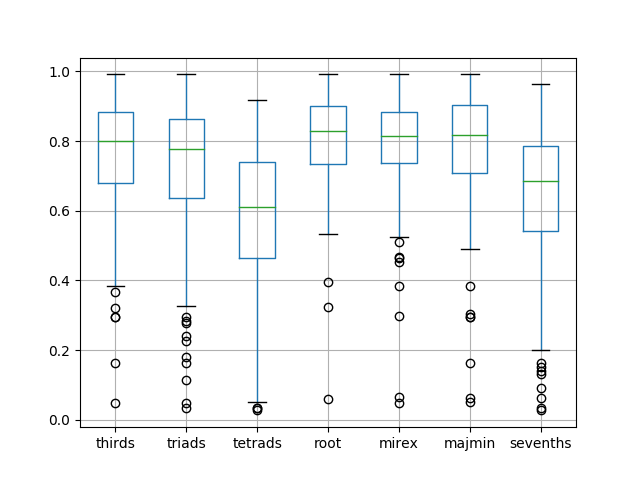

In [41]:
plt.figure()
dfr.boxplot();

In [42]:
dfr.describe().loc['mean']

thirds      0.769563
triads      0.727529
tetrads     0.590000
root        0.804221
mirex       0.794089
majmin      0.783547
sevenths    0.646078
Name: mean, dtype: float64

In [43]:
F = idx_val.index[99]

In [44]:
#F = df['mirex'].argmin()

In [45]:
F

'TRNLAON149E3C7A10A'

In [46]:
datum = np.load('/home/bmcfee/working/chords/pump/{}.npz'.format(F))

In [47]:
J = jams.load('/home/bmcfee/data/eric_chords/references_v2/{}.jams'.format(F))

In [48]:
ann_true = pump['chord_tag'].inverse(datum['chord_tag/chord'][0])

In [49]:
ann = pump['chord_tag'].inverse(model.predict(datum['cqt/mag'])[0])

In [50]:
pd.DataFrame.from_records([jams.eval.chord(J.annotations['chord', 0], ann)]).loc[0]

thirds          0.848426
thirds_inv      0.786175
triads          0.798529
triads_inv      0.736278
tetrads         0.628914
tetrads_inv     0.594858
root            0.848883
mirex           0.840173
majmin          0.848065
majmin_inv      0.779173
sevenths        0.661888
sevenths_inv    0.624199
Name: 0, dtype: float64

<IPython.core.display.Javascript object>


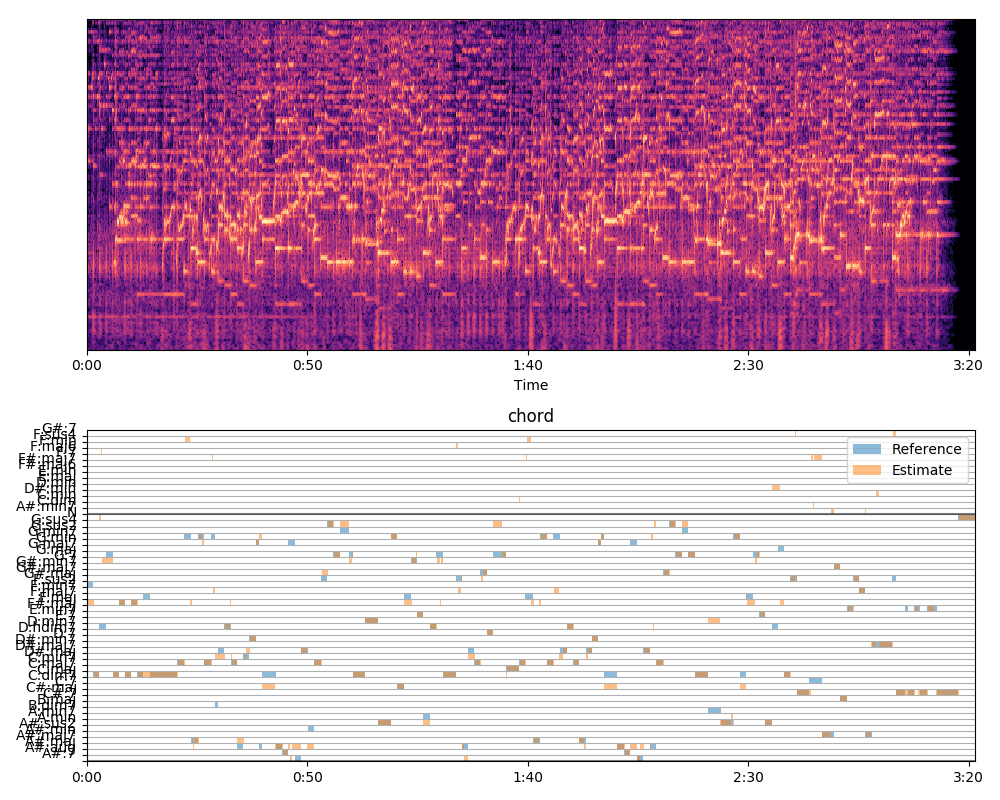

In [51]:
plt.figure(figsize=(10, 8))

ax = plt.subplot(2,1,1)
librosa.display.specshow(datum['cqt/mag'][0, :, :, 0].T,
                         sr=pump.ops[0].sr,
                         hop_length=pump.ops[0].hop_length,
                         x_axis='time')

plt.subplot(2,1,2, sharex=ax)
jams.display.display(ann_true, meta=False, label='Reference', alpha=0.5)
jams.display.display(ann, meta=False, label='Estimate', alpha=0.5)
plt.legend()
plt.tight_layout()

In [ ]:
y, sr = librosa.load('/home/bmcfee/data/eric_chords/audio/{}.mp3'.format(F), sr=8000)

In [ ]:
Audio(data=np.vstack([y, jams.sonify.sonify(ann, sr=sr, duration=int(np.ceil(len(y) / sr)))[:len(y)]]),
      rate=sr)